In [1]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier

In [2]:
import torchvision.models as models
import torch.nn as nn
from torch import cat
vgg16 = models.vgg16()

In [ ]:
momentum = 0.9
weight_decay = 0.0005
batch_size = 16
learn_rate = [1e-3, 1e-4, 1e-5]
learn_amounts = [40000, 10000, 10000]

In [ ]:
def FEM(i, j, l, upper_layer):
    enhanced_neuron = torch.cat()

In [ ]:
truncated_model = nn.Sequential(*list(vgg16.children()))[:-1]

## Begin Second Attempt

Note: referenced from https://github.com/timesler/facenet-pytorch/blob/master/examples/face_tracking.ipynb

In [ ]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import cv2

ModuleNotFoundError: ignored

In [3]:
import matplotlib.pyplot as plt

In [ ]:
mtcnn = MTCNN(keep_all=True, device='cpu')

In [ ]:
frame = cv2.cvtColor(cv2.imread('samples/input_img_with_face.jpeg'), cv2.COLOR_BGR2RGB)

[ WARN:0@13375.420] global loadsave.cpp:244 findDecoder imread_('samples/input_img_with_face.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /Users/opencv-cn/GHA-OCV-3/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
boxes, confidence = mtcnn.detect(frame)

In [ ]:
masked = frame.copy()

for i, detected in enumerate(boxes):
    if confidence[i] < .5:
        continue
    
    [x1, y1, x2, y2] = detected
    
    # adjust mask smaller so face replacement has more to work with
    x_adj = abs(x2-x1) / 8
    y_adj = abs(y2-y1) / 8
    x1 = int(x1 + x_adj)
    x2 = int(x2 - x_adj)
    y1 = int(y1 + y_adj)
    y2 = int(y2 - y_adj)
    
    masked[y1:y2,x1:x2] = np.random.rand(y2-y1, x2-x1, 3) * 255

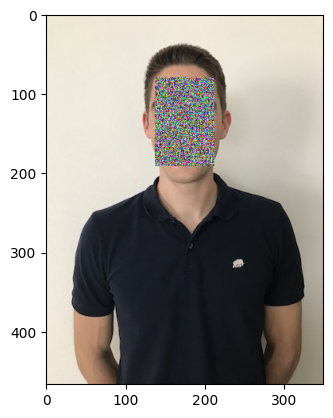

In [ ]:
plt.imshow(masked)

## Implementation of Face Detector

Note: Referred to the paper at https://kpzhang93.github.io/MTCNN_face_detection_alignment/paper/spl.pdf

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import torch
import numpy as np
import cv2

In [6]:
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

training_data = torchvision.datasets.WIDERFace(
    root="widerface",
    split="train",
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.WIDERFace(
    root="widerface",
    split="val",
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
import torch.nn as nn
import numpy as np
import torch

class FaceDetector(nn.Module):
    def __init__(self, in_channels=3):
        super(FaceDetector, self).__init__()
        
        self.p_net = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1),
            nn.PReLU(10),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1),
            nn.PReLU(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.PReLU(32),
        )
        self.p_face = nn.Conv2d(32, 1, kernel_size=1)
        self.p_bound = nn.Conv2d(32, 4, kernel_size=1)
        self.p_landmark = nn.Conv2d(32, 10, kernel_size=1)
        
        self.r_net = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1, padding=1),
            nn.PReLU(28),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(28, 48, kernel_size=3, stride=1, padding=1),
            nn.PReLU(48),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(48, 64, kernel_size=2, stride=1, padding=1),
            nn.PReLU(64)
        )
        self.r_lin = nn.Linear(2304, 128)
        self.r_prelu = nn.PReLU(128)
        self.r_face = nn.Linear(128, 1)
        self.r_bound = nn.Linear(128,  4)
        self.r_landmark = nn.Linear(128, 10)
        
        self.o_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.PReLU(32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.PReLU(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.PReLU(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.PReLU(128)
        )
        self.o_lin = nn.Linear(4608, 256)
        self.o_prelu = nn.PReLU(256)
        self.o_face = nn.Linear(256, 1)
        self.o_bound = nn.Linear(256,  4)
        self.o_landmark = nn.Linear(256,  10)


    
    def p_forward(self, x):
        # assume x has already been resized to appropriate size 12x12
        x1 = self.p_net(x)
        face = self.p_face(x1).flatten()
        bounds = self.p_bound(x1).squeeze(0).flatten(start_dim=1).transpose(0,1)
        landmark = self.p_landmark(x1)
        return face, bounds, landmark
    
    def r_forward(self, x):
        # assume x has already been resized to appropriate size 24x24
        x1 = self.r_net(x)
        x1 = x1.permute(0,3,2,1).contiguous()
        x1 = self.r_lin(x1.view(x1.shape[0], -1))
        x1 = self.r_prelu(x1)
        face = self.r_face(x1).squeeze(0)
        bounds = self.r_bound(x1)
        landmark = self.r_landmark(x1)
        return face, bounds, landmark
    
    def o_forward(self, x):
        # assume x has already been resized to appropriate size 48x48
        x1 = self.o_net(x)
        x1 = x1.permute(0,3,2,1).contiguous()
        x1 = self.o_lin(x1.view(x1.shape[0], -1))
        x1 = self.o_prelu(x1)
        face = self.o_face(x1).squeeze(0)
        bounds = self.o_bound(x1)
        landmark = self.o_landmark(x1)
        return face, bounds, landmark
        
        

In [8]:
face_detector = FaceDetector()

classify_loss = nn.BCELoss()
bound_loss = nn.MSELoss()
landmark_loss = nn.MSELoss()

optimizer = torch.optim.SGD(face_detector.parameters(), lr = 0.002)


In [9]:
def detect_faces(image_in, detector):
    #image_in = to_numpy_img(image_in)
    #im_12 = torch.from_numpy(cv2.resize(image_in, [12, 12]))
    im_12 = torchvision.transforms.ToTensor()(cv2.resize(image_in, [12, 12])).unsqueeze(0)
    #im_24 = torch.from_numpy(cv2.resize(image_in, [24, 24]))
    im_24 = torchvision.transforms.ToTensor()(cv2.resize(image_in, [24, 24])).unsqueeze(0)
    #im_48 = torch.from_numpy(cv2.resize(image_in, [48, 48]))
    im_48 = torchvision.transforms.ToTensor()(cv2.resize(image_in, [48, 48])).unsqueeze(0)
    
    face, bounds, landmark = detector.p_forward(im_12)
    kept_idxs = torchvision.ops.nms(bounds, face, 0.5)
    face_12 = face[kept_idxs]
    bounds_12 = bounds[kept_idxs]
    
    face, bounds, landmark = detector.r_forward(im_24)
    bounds = torch.cat((bounds, bounds_12*2), 0)
    face = torch.cat((face, face_12), 0)
    kept_idxs = torchvision.ops.nms(bounds, face, 0.7)
    face_24 = face[kept_idxs]
    bounds_24 = bounds[kept_idxs]
    
    face, bounds, landmark = detector.o_forward(im_48)
    bounds = torch.cat((bounds, bounds_24*2), 0)
    face = torch.cat((face, face_24), 0)
    kept_idxs = torchvision.ops.nms(bounds, face, 0.7)
    face_48 = face[kept_idxs]
    bounds_48 = bounds[kept_idxs]
    
    return face_48, bounds_48

In [38]:
def evaluate_model(classify_loss, bound_loss, landmark_loss, face_detector, test_dataloader):
    mean_classify_loss, mean_bound_loss, mean_landmark_loss = 0, 0, 0
    for image, im_info in test_data:
        image = image.to(device)
        
        image_np = to_numpy_img(image)
        estimated_label, estimated_bounds = detect_faces(image_np, face_detector)
        estimated_int_bounds = torch.Tensor.int(estimated_bounds)

        # find max shape
        num_labels = max(len(im_info['invalid']), estimated_label.shape[0])
        num_bounds = max(im_info['bbox'].shape[0], estimated_bounds.shape[0])

        # assign based on max shape
        estimated_label_max = torch.zeros(num_labels)
        estimated_bounds_max = torch.zeros((num_bounds, 4))

        estimated_label_max[:estimated_label.shape[0]] = estimated_label
        estimated_bounds_max[:estimated_bounds.shape[0],] = estimated_bounds

        true_label = torch.zeros(estimated_label_max.shape)
        true_label[:len(im_info['invalid'])] = 1
        true_bound = torch.zeros(estimated_bounds_max.shape)
        real_bounds = corner_size_to_coords(im_info['bbox'])
        true_bound[:real_bounds.shape[0],] = real_bounds

        mean_classify_loss += classify_loss(true_label, estimated_label_max)
        mean_bound_loss += bound_loss(true_bound, estimated_bounds_max)
        
    mean_classify_loss /= len(test_data)
    mean_bound_loss /= len(test_data)
    return mean_classify_loss, mean_bound_loss

In [39]:
def to_numpy_img(dataset_img):
  return dataset_img.numpy().transpose(1, 2, 0)

In [40]:
evaluate_model(classify_loss, bound_loss, landmark_loss, face_detector, test_dataloader)

(tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>))

In [12]:
(image, im_info) = training_data[0]
image_in = to_numpy_img(image)
detector = face_detector

im_12 = torchvision.transforms.ToTensor()(cv2.resize(image_in, [12, 12])).unsqueeze(0)
face, bounds, landmark = detector.p_forward(im_12)
kept_idxs = torchvision.ops.nms(bounds, face, 0.5)
face_12 = face[kept_idxs]
bounds_12 = bounds[kept_idxs]
print(bounds_12)

estimated_label, estimated_bounds = detect_faces(image_in, face_detector)
print(estimated_bounds)
true_bound = torch.zeros(estimated_bounds.shape)
real_bounds = im_info['bbox']
print(real_bounds)
new_bounds = corner_size_to_coords(real_bounds)
print(new_bounds)
plt.imshow(image_in)

tensor([[ 0.0450,  0.0373, -0.0857, -0.1038],
        [ 0.0515,  0.0311, -0.0906, -0.1051],
        [ 0.0597,  0.0236, -0.0706, -0.1177],
        [ 0.0557,  0.0219, -0.0881, -0.1063],
        [ 0.0536,  0.0341, -0.0938, -0.1096],
        [ 0.0658,  0.0333, -0.0897, -0.1035],
        [ 0.0476,  0.0365, -0.0847, -0.1122],
        [ 0.0485,  0.0245, -0.0791, -0.1096],
        [ 0.0441,  0.0394, -0.0929, -0.0982],
        [ 0.0636,  0.0288, -0.0813, -0.1175],
        [ 0.0739,  0.0321, -0.0841, -0.1217],
        [ 0.0718,  0.0335, -0.0916, -0.1081],
        [ 0.0542,  0.0351, -0.0883, -0.1082],
        [ 0.0530,  0.0380, -0.0751, -0.1144],
        [ 0.0561,  0.0364, -0.0920, -0.1037],
        [ 0.0515,  0.0485, -0.0887, -0.1022],
        [ 0.0656,  0.0400, -0.0740, -0.1212],
        [ 0.0664,  0.0388, -0.0772, -0.1219],
        [ 0.0488,  0.0437, -0.0920, -0.1063],
        [ 0.0621,  0.0408, -0.0883, -0.1117],
        [ 0.0607,  0.0344, -0.1094, -0.0900],
        [ 0.0474,  0.0327, -0.0950

NameError: ignored

In [30]:
def detected_face(im_in, bounds):
  if len(bounds.shape) > 1:
    bounds = bounds[0,]
  x1, y1, x2, y2 = bounds
  return im_in[y1:y2, x1:x2]

In [31]:
def corner_size_to_coords(corner_size):
  out = torch.clone(corner_size)
  squeeze_result = False
  if len(out.shape) == 1:
    out = out.unsqueeze(0)
    squeeze_result = True
  out[:,2] = out[:,0] + out[:,2]
  out[:,3] = out[:,1] + out[:,3]
  if squeeze_result:
    out = out.squeeze(0)
  return out

def coords_to_corner_size(coords):
  out = torch.clone(coords)
  squeeze_result = False
  if len(out.shape) == 1:
    out = out.unsqueeze(0)
    squeeze_result = True
  out[:,2] = out[:,2] - out[:,0]
  out[:,3] = out[:,3] - out[:,1]
  if squeeze_result:
    out = out.squeeze(0)
  return out

coords = torch.tensor([1,2,2,2])
corner_size = torch.tensor([[1,2,3,4]])
coords_to_corner_size(corner_size)

tensor([[1, 2, 2, 2]])

Invalid image shown


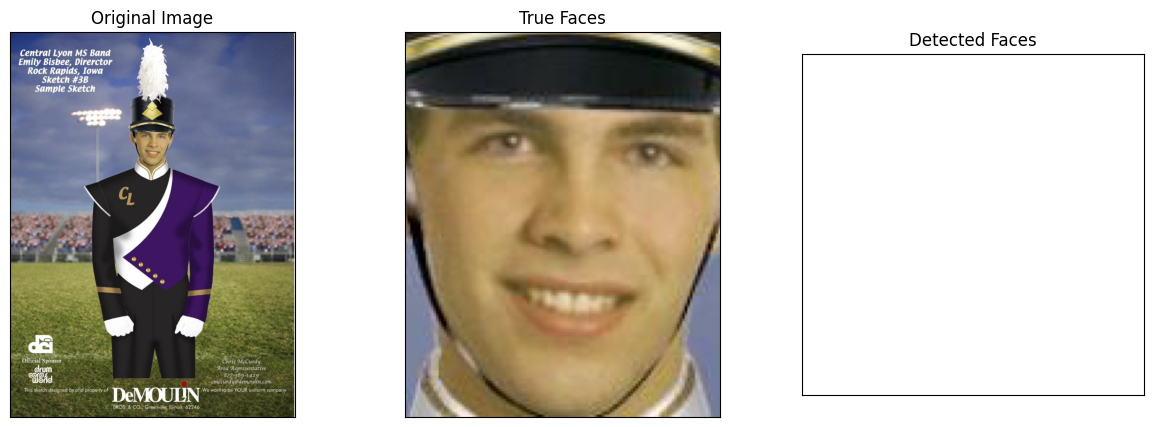

Invalid image shown


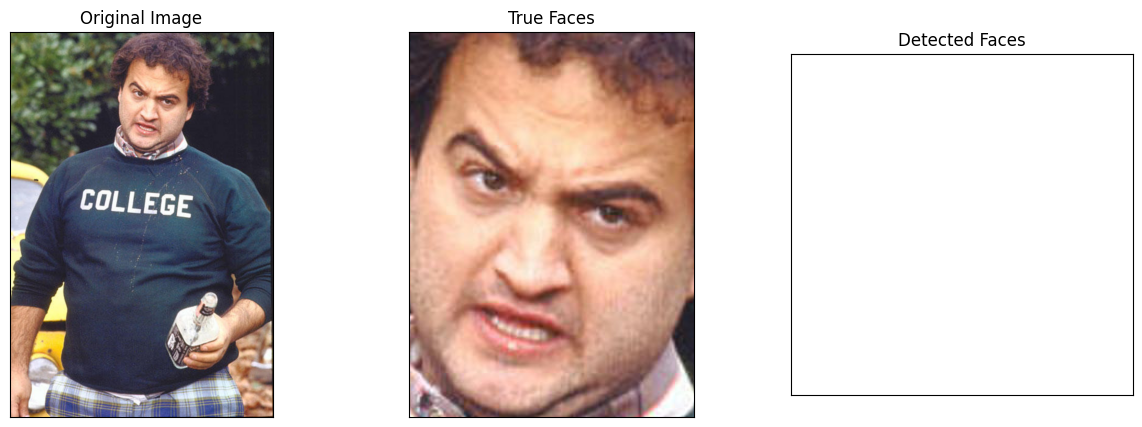

In [ ]:
import os
import copy

save_path = '.'
num_epochs = 30
best_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    for i, (image, im_info) in enumerate(training_data):
        # Resize the images and masks to a consistent size
        image = image.to(device)

        # detect faces with p, r, o nets
        image_np = to_numpy_img(image)
        estimated_label, estimated_bounds = detect_faces(image_np, face_detector)
        estimated_int_bounds = torch.Tensor.int(estimated_bounds)

        # find max shape
        num_labels = max(len(im_info['invalid']), estimated_label.shape[0])
        num_bounds = max(im_info['bbox'].shape[0], estimated_bounds.shape[0])

        # assign based on max shape
        estimated_label_max = torch.zeros(num_labels)
        estimated_bounds_max = torch.zeros((num_bounds, 4))

        estimated_label_max[:estimated_label.shape[0]] = estimated_label
        estimated_bounds_max[:estimated_bounds.shape[0],] = estimated_bounds

        true_label = torch.zeros(estimated_label_max.shape)
        true_label[:len(im_info['invalid'])] = 1
        true_bound = torch.zeros(estimated_bounds_max.shape)
        real_bounds = corner_size_to_coords(im_info['bbox'])
        true_bound[:real_bounds.shape[0],] = real_bounds

        if i % 10000 == 0:
          fig, axs = plt.subplots(1, 3, figsize=(15, 5))
          axs[0].imshow(image_np)
          axs[0].set_title("Original Image")
          axs[1].imshow(detected_face(image_np, real_bounds))
          axs[1].set_title("True Faces")
          try:
            axs[2].imshow(detected_face(image_np, estimated_int_bounds))
          except:
            print("Invalid image shown")
          axs[2].set_title("Detected Faces")

          for ax in axs:
              ax.set_xticks([])
              ax.set_yticks([])

          plt.show()
        
        loss = classify_loss(true_label, estimated_label_max) + bound_loss(true_bound, estimated_bounds_max)

        # back-prop the losses
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
    # Evaluate after each epoch
    mean_face_loss, mean_bound_loss = evaluate_model(classify_loss, bound_loss, landmark_loss, face_detector, test_data)
    print(f"Epoch: {epoch}, Face Loss: {mean_face_loss:.4f}, Bound Loss: {mean_bound_loss:.4f}")

    
    if mean_bound_loss < best_loss:
        best_loss = mean_bound_loss
        best_net = copy.deepcopy(face_detector.state_dict())
        # Save the best models
        torch.save(best_net, os.path.join(save_path, 'face_detector.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break